<a href="https://colab.research.google.com/github/maddysshaw/Cognitive_AI_2024/blob/main/Coursework2a2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NeuroGym is a curated collection of neuroscience tasks, with a common interface,
designed to facilitate training of neural network models on neuroscience tasks.

# 2. (a)
Initially, your goal is to train and compare multiple (at least two) models to
perform one of these tasks. One model should be a standard recurrent neural
network model (e.g. vanilla RNN, leaky RNN, light GRU, GRU, LSTM). One or
more of the other models you implement should differ from the standard model
based on a brain-inspired change (which you described in your answer to
question 1). Describe your models including equations and schematic diagrams,
highlighting the key differences. [10 marks]

In [1]:
# Import common packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

# **Setting Up a Vanilla RNN**

In [2]:
class VanillaRNN(nn.Module):
    """Vanilla RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """
    def __init__(self, input_size, hidden_size, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.tanh(self.input2h(input) + self.h2h(hidden))
        return h_new

    def forward(self, input, hidden=None):
        """Propagate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model using Vanilla RNN.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Vanilla RNN
        self.rnn = VanillaRNN(input_size, hidden_size, **kwargs)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

# **Implementing Feedback Alignment**

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class FeedbackAlignedRNN(nn.Module):
    """Feedback-aligned Vanilla RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """
    def __init__(self, input_size, hidden_size, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Define forward weights
        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

        # Define fixed random feedback weights
        self.feedback_weights = nn.Parameter(torch.randn(hidden_size, hidden_size), requires_grad=False)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step."""
        h_new = torch.tanh(self.input2h(input) + self.h2h(hidden))
        return h_new

    def forward(self, input, hidden=None):
        """Propagate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        for i in range(input.size(0)):
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack outputs from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class FARNN(nn.Module):
    """Feedback-Aligned RNN.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Feedback-Aligned RNN
        self.rnn = FeedbackAlignedRNN(input_size, hidden_size, **kwargs)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

        # Feedback weights for the output layer
        self.output_feedback_weights = nn.Parameter(torch.randn(output_size, hidden_size), requires_grad=False)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

    def feedback_alignment_update(self, optimizer, output, target):
        """Custom backward pass using feedback alignment."""
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)

        # Compute gradients for the output layer
        output_grad = torch.autograd.grad(loss, output, create_graph=True)[0]

        # Update output layer weights using fixed feedback weights
        with torch.no_grad():
            self.fc.weight.grad = torch.mm(output_grad, self.output_feedback_weights).t()
            self.fc.bias.grad = output_grad.sum(dim=0)

        # Compute gradients for RNN hidden weights using feedback weights
        for i in reversed(range(output.size(0))):
            hidden_grad = torch.mm(output_grad, self.rnn.feedback_weights)
            for param in self.rnn.parameters():
                if param.requires_grad:
                    param.grad = torch.autograd.grad(output[i], param, grad_outputs=hidden_grad, retain_graph=True)[0]

        # Apply optimizer step
        optimizer.step()
        optimizer.zero_grad()

# **Implementing Dale's Law**

In [44]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math

class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal

        #First create a mask to remove the diagonal (matrix size hidden_size*hidden_size)
        mask_no_diag = torch.ones(hidden_size, hidden_size) - torch.eye(hidden_size)
        # Define the excitatory an inhibitory units with columns of 1s and -1s (use e_size and i_size)
        exc = np.ones(self.e_size)
        inh = -np.ones(self.i_size)
        E_I_unit_list = np.concatenate((exc, inh)).T

        mask = mask_no_diag * E_I_unit_list

        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask you have already created to the weights after applying rectification to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        eff_W = F.relu(self.weight)*self.mask
        return eff_W

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)

class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise parameter, scaled by the discretization (sqrt(2*alpha)) and noise level (sigma_rec)
        # This adds stochasticity to the recurrent dynamics, possibly simulating biological neural variability
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

        print(f"Hidden type: {type(hidden)}, Hidden content: {hidden}")
        print(f"State type: {type(state)}, State content: {state}")
        print(f"Output type: {type(output)}, Output content: {output}")

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden

class EINet(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity



---



# 2. (b)
Compare your models both in how well they learn to perform the task, and by
analysing the hidden unit activity of the trained models to understand how the
trained models solve the task. Highlight and interpret any differences between
the models. [20 marks]



Import task from neurogym library

In [5]:
# Install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

fatal: destination path 'neurogym' already exists and is not an empty directory.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
  Attempting uninstall: neurogym
    Found existing installation: neurogym 0.0.2
    Uninstalling neurogym-0.0.2:
      Successfully uninstalled neurogym-0.0.2
  Running setup.py develop for neurogym


# Importing Task 1: Perceptual Decision Making

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


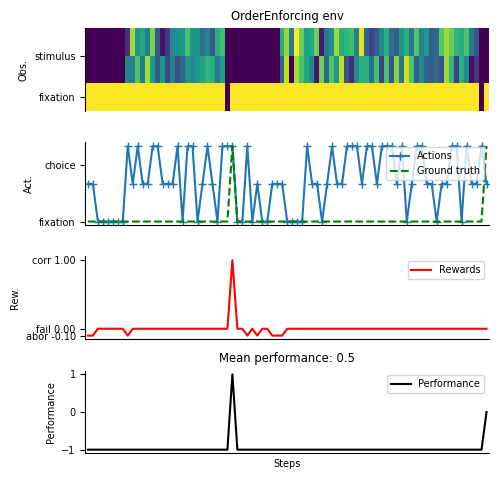

In [6]:
import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task = 'PerceptualDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

Train Networks on Decision Making (Task 1)

RNNNet(
  (rnn): VanillaRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=3, bias=True)
)
Step 200, Loss 0.2934
Step 400, Loss 0.1368
Step 600, Loss 0.0840
Step 800, Loss 0.0709
Step 1000, Loss 0.0694
Step 1200, Loss 0.0630
Step 1400, Loss 0.0629
Step 1600, Loss 0.0624
Step 1800, Loss 0.0603
Step 2000, Loss 0.0603
Step 2200, Loss 0.0621
Step 2400, Loss 0.0593
Step 2600, Loss 0.0570
Step 2800, Loss 0.0571
Step 3000, Loss 0.0579
Step 3200, Loss 0.0587
Step 3400, Loss 0.0583
Step 3600, Loss 0.0576
Step 3800, Loss 0.0579
Step 4000, Loss 0.0580
Step 4200, Loss 0.0552
Step 4400, Loss 0.0588
Step 4600, Loss 0.0578
Step 4800, Loss 0.0567
Step 5000, Loss 0.0567


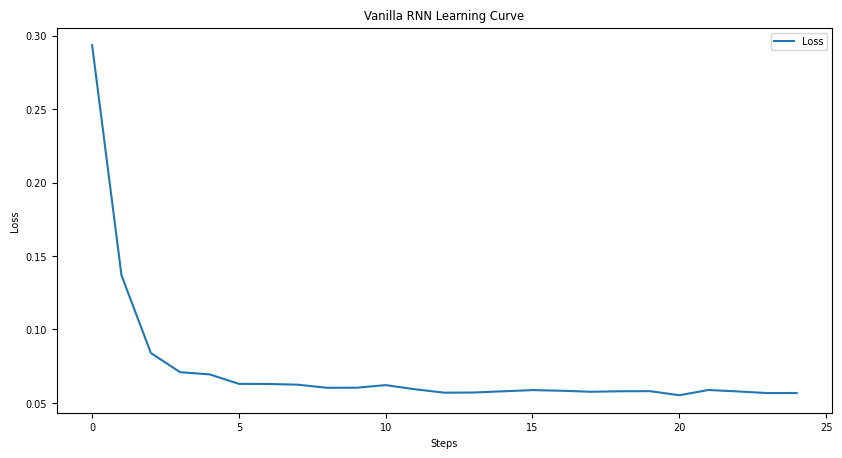

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs) # returns hidden unit activity
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Vanilla RNN Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

FA-RNN Step 200, Loss 0.2896
FA-RNN Step 400, Loss 0.1203
FA-RNN Step 600, Loss 0.0826
FA-RNN Step 800, Loss 0.0731
FA-RNN Step 1000, Loss 0.0678
FA-RNN Step 1200, Loss 0.0651
FA-RNN Step 1400, Loss 0.0653
FA-RNN Step 1600, Loss 0.0626
FA-RNN Step 1800, Loss 0.0612
FA-RNN Step 2000, Loss 0.0607
FA-RNN Step 2200, Loss 0.0607
FA-RNN Step 2400, Loss 0.0579
FA-RNN Step 2600, Loss 0.0596
FA-RNN Step 2800, Loss 0.0571
FA-RNN Step 3000, Loss 0.0594
FA-RNN Step 3200, Loss 0.0585
FA-RNN Step 3400, Loss 0.0591
FA-RNN Step 3600, Loss 0.0571
FA-RNN Step 3800, Loss 0.0576
FA-RNN Step 4000, Loss 0.0578
FA-RNN Step 4200, Loss 0.0564
FA-RNN Step 4400, Loss 0.0585
FA-RNN Step 4600, Loss 0.0559
FA-RNN Step 4800, Loss 0.0586
FA-RNN Step 5000, Loss 0.0574


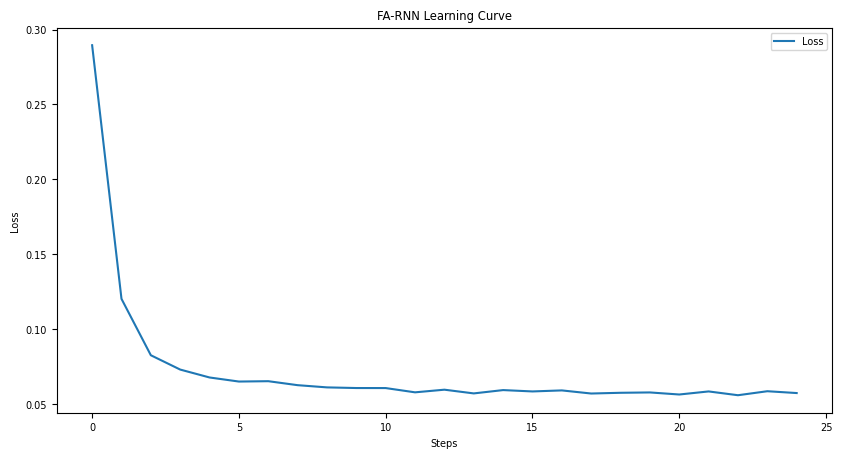

In [8]:
# Training loop for FA-RNN
fa_net = FARNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dt=env.dt, sigma_rec=0.15)

optimizer = optim.Adam(fa_net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

fa_loss_values = []  # List to store loss values
fa_running_loss = 0.0

for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    optimizer.zero_grad()

    # Forward pass
    output, activity = fa_net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass (standard gradient update, but with feedback alignment)
    loss.backward()

    # Apply gradient updates
    optimizer.step()

    fa_running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = fa_running_loss / print_step
        print(f"FA-RNN Step {i+1}, Loss {average_loss:.4f}")
        fa_loss_values.append(average_loss)
        fa_running_loss = 0.0

# Plotting FA-RNN loss curve
plt.figure(figsize=(10,5))
plt.title("FA-RNN Learning Curve")
plt.plot(fa_loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


<ipython-input-4-f3d3cee2f0c2>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask = torch.tensor(mask, dtype=torch.float32)


EINet(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
EI-RNN Step 200, Loss 0.5498
EI-RNN Step 400, Loss 0.3227
EI-RNN Step 600, Loss 0.2329
EI-RNN Step 800, Loss 0.1838
EI-RNN Step 1000, Loss 0.1468
EI-RNN Step 1200, Loss 0.1269
EI-RNN Step 1400, Loss 0.1109
EI-RNN Step 1600, Loss 0.0982
EI-RNN Step 1800, Loss 0.0910
EI-RNN Step 2000, Loss 0.0855
EI-RNN Step 2200, Loss 0.0803
EI-RNN Step 2400, Loss 0.0742
EI-RNN Step 2600, Loss 0.0731
EI-RNN Step 2800, Loss 0.0706
EI-RNN Step 3000, Loss 0.0701
EI-RNN Step 3200, Loss 0.0671
EI-RNN Step 3400, Loss 0.0668
EI-RNN Step 3600, Loss 0.0661
EI-RNN Step 3800, Loss 0.0647
EI-RNN Step 4000, Loss 0.0640
EI-RNN Step 4200, Loss 0.0623
EI-RNN Step 4400, Loss 0.0650
EI-RNN Step 4600, Loss 0.0627
EI-RNN Step 4800, Loss 0.0615
EI-RNN Step 5000, Loss 0.0613


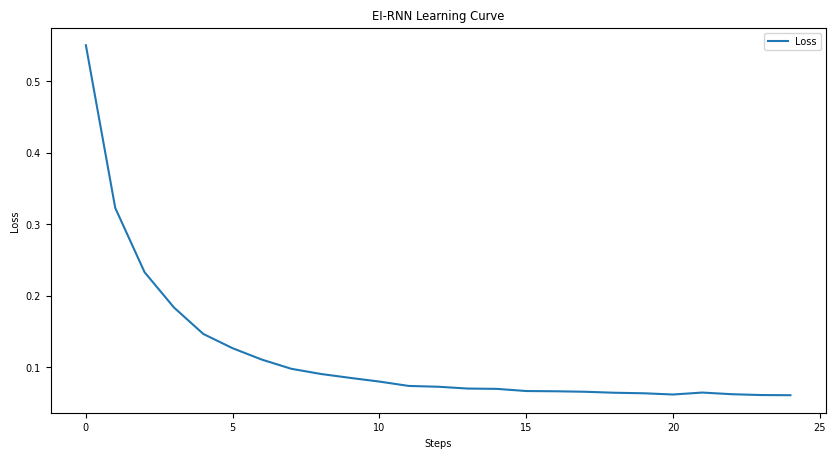

In [9]:
# Instantiate the network
hidden_size = 50
EI_net = EINet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(EI_net)

# Use Adam optimizer
optimizer = optim.Adam(EI_net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

EI_loss_values = []  # List to store loss values
EI_running_loss = 0.0
#print_step = 200
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = EI_net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    EI_running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = EI_running_loss / print_step
        print('EI-RNN Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        EI_loss_values.append(average_loss)  # Append average loss here
        EI_running_loss = 0.0

# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("EI-RNN Learning Curve")
plt.plot(EI_loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Hidden Layer Activity Analysis

In [10]:
# @title Run the network post-training and record neural activity

env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})

def record_neural_activity(model, env, title_suffix=''):

  perf = 0
  num_trial = 500
  activity_dict = {}
  trial_infos = {}
  stim_activity = [[], []]  # response for ground-truth 0 and 1

#def record_neural_activity(model, env, title_suffix=''):
  for i in range(num_trial):
      env.new_trial()
      ob, gt = env.ob, env.gt
      inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
      action_pred, rnn_activity = model(inputs)

      # Compute performance
      action_pred = action_pred.detach().numpy()
      choice = np.argmax(action_pred[-1, 0, :])
      correct = choice == gt[-1]

      # Log trial info
      trial_info = env.trial
      trial_info.update({'correct': correct, 'choice': choice})
      trial_infos[i] = trial_info

      # Log stimulus period activity
      rnn_activity = rnn_activity[:, 0, :].detach().numpy()
      activity_dict[i] = rnn_activity

      # Compute stimulus selectivity for all units
      # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
      rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
      stim_activity[env.trial['ground_truth']].append(rnn_activity)
  print(f'Average performance of {title_suffix}', np.mean([val['correct'] for val in trial_infos.values()]))

  return rnn_activity, action_pred, trial_infos, activity_dict, stim_activity
  #print(f'Average performance of {title_suffix}', np.mean([val['correct'] for val in trial_infos.values()]))

rnn_activity, action_pred, trial_infos, activity_dict, stim_activity = record_neural_activity(net, env, title_suffix='Vanilla RNN')
fa_rnn_activity, fa_action_pred, fa_trial_infos, fa_activity_dict, fa_stim_activity = record_neural_activity(fa_net, env, title_suffix='Feedback-Aligned RNN')
ei_rnn_activity, ei_action_pred, ei_trial_infos, ei_activity_dict, ei_stim_activity = record_neural_activity(EI_net, env, title_suffix='Excitatory-Inhibitory RNN')

Average performance of Vanilla RNN 0.856
Average performance of Feedback-Aligned RNN 0.876
Average performance of Excitatory-Inhibitory RNN 0.83


Text(0, 0.5, 'Activity')

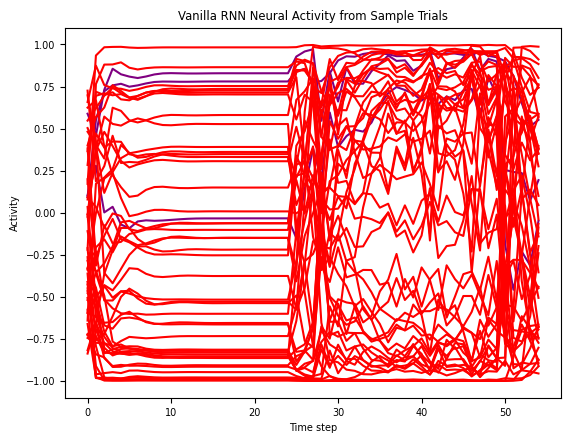

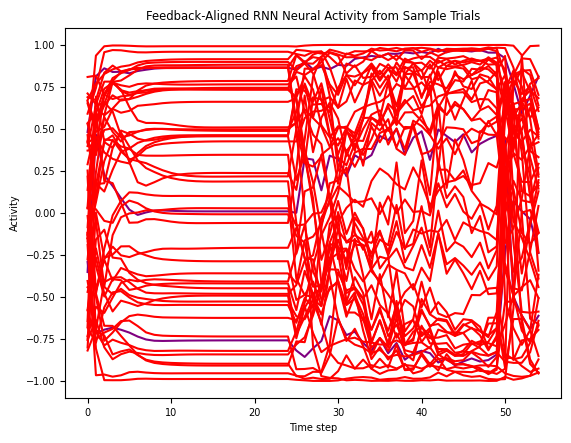

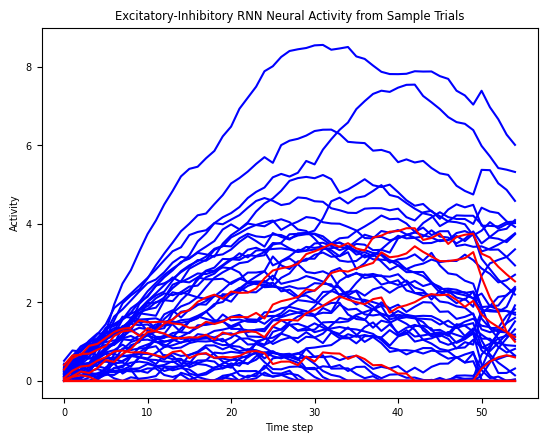

In [47]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

e_size = EI_net.rnn.e_size
input_size = net.rnn.input_size
fa_input_size = fa_net.rnn.input_size
trial = 2

plt.figure()
_ = plt.plot(activity_dict[trial][:, :input_size], color='purple', label='Excitatory')
_ = plt.plot(activity_dict[trial][:, input_size:], color='red', label='Inhibitory')
plt.title('Vanilla RNN Neural Activity from Sample Trials')
plt.xlabel('Time step')
plt.ylabel('Activity')

plt.figure()
_ = plt.plot(fa_activity_dict[trial][:, :fa_input_size], color='purple', label='Excitatory')
_ = plt.plot(fa_activity_dict[trial][:, fa_input_size:], color='red', label='Inhibitory')
plt.title('Feedback-Aligned RNN Neural Activity from Sample Trials')
plt.xlabel('Time step')
plt.ylabel('Activity')

plt.figure()
_ = plt.plot(ei_activity_dict[trial][:, :e_size], color='blue', label='Excitatory')
_ = plt.plot(ei_activity_dict[trial][:, e_size:], color='red', label='Inhibitory')
plt.title('Excitatory-Inhibitory RNN Neural Activity from Sample Trials')
plt.xlabel('Time step')
plt.ylabel('Activity')

# PCA Analysis of the Networks

Performing PCA for the Vanilla RNN...
Shape of the neural activity (Time points, Neurons) for Vanilla RNN: (27500, 50)
Shape of the projected activity (Time points, PCs) for Vanilla RNN: (27500, 2)


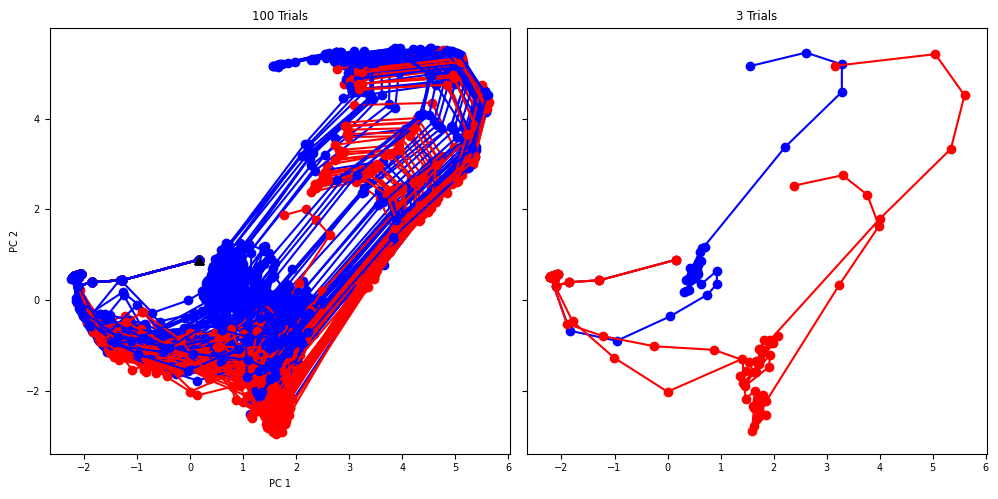

Performing PCA for the Feedback-Aligned RNN...
Shape of the neural activity (Time points, Neurons) for Feedback-Aligned RNN: (27500, 50)
Shape of the projected activity (Time points, PCs) for Feedback-Aligned RNN: (27500, 2)


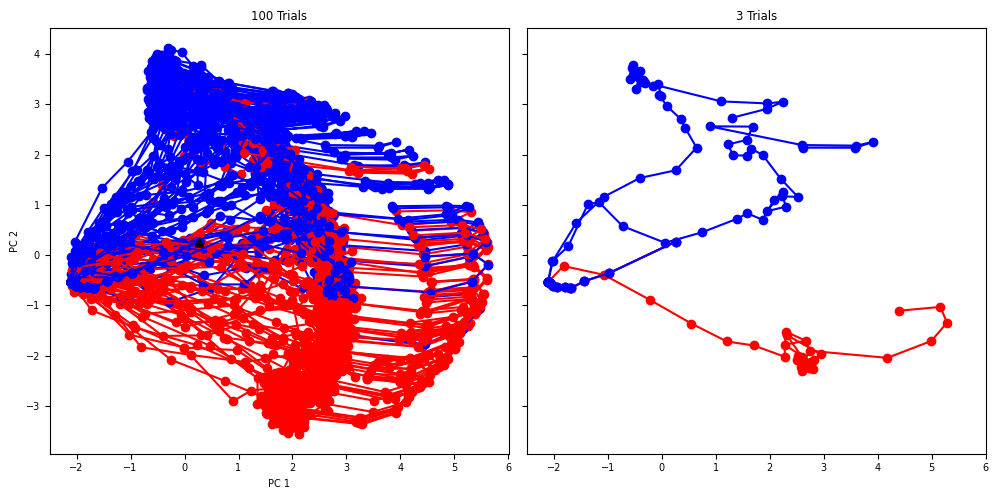

Performing PCA for the Excitatory-Inhibitory RNN...
Shape of the neural activity (Time points, Neurons) for Excitatory-Inhibitory RNN: (27500, 50)
Shape of the projected activity (Time points, PCs) for Excitatory-Inhibitory RNN: (27500, 2)


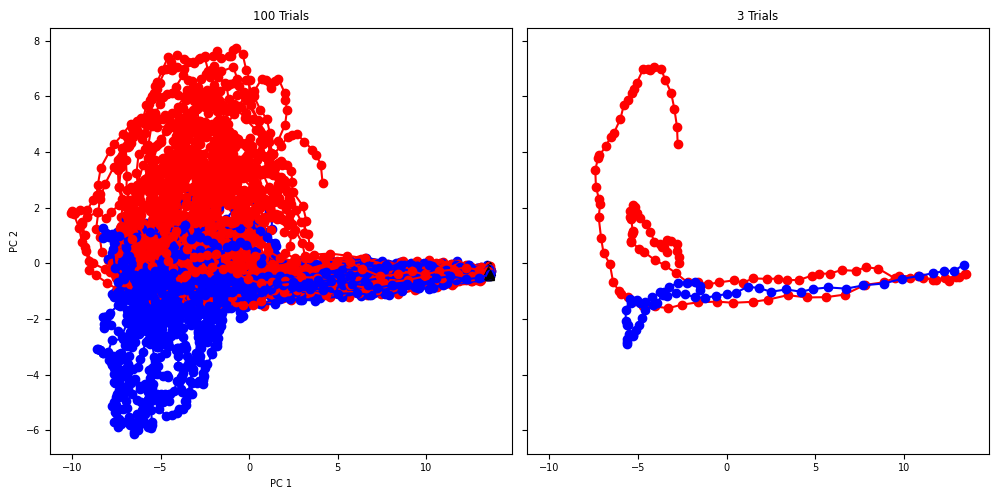

In [12]:

# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyse

### Play with different values here to understand the dynamics
plot_until_time = 70


def pca_analysis(activity_dict, trial_infos, title_suffix=''):
  # Concatenate activity data across all trials for PCA
  activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
  # print('Shape of the neural activity (Time points, Neurons):', activity.shape)
  print(f'Shape of the neural activity (Time points, Neurons) for {title_suffix}:', activity.shape)

  # Initialize PCA and fit it on the activity data
  pca = PCA(2)  # Using 2 components for visualization
  pca.fit(activity)
  activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D) - hint ".transform" could he helpful
  print(f'Shape of the projected activity (Time points, PCs) for {title_suffix}:', activity_pc.shape)

  # Visualization
  fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

  # Plot all trials in ax1 and fewer trials in ax2 for clarity
  for i in range(100):
      # Transform and plot each trial
      activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

      # Color by ground truth
      trial = trial_infos[i]
      color = 'red' if trial['ground_truth'] == 0 else 'blue'

      ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
      if i < 3:  # Fewer trials in ax2 for clear visualization
          ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

      # Indicate trial start with a different marker
      ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

  # Setting labels and titles for clarity
  ax1.set_title('100 Trials')
  ax2.set_title('3 Trials')
  ax1.set_xlabel('PC 1')
  ax1.set_ylabel('PC 2')

  plt.tight_layout()
  plt.show()

print("Performing PCA for the Vanilla RNN...")
pca_analysis(activity_dict, trial_infos, title_suffix='Vanilla RNN')

print("Performing PCA for the Feedback-Aligned RNN...")
pca_analysis(fa_activity_dict, fa_trial_infos, title_suffix='Feedback-Aligned RNN')

print("Performing PCA for the Excitatory-Inhibitory RNN...")
pca_analysis(ei_activity_dict, ei_trial_infos, title_suffix='Excitatory-Inhibitory RNN')

# good to change the number of timepoints you visualise to see variation and potential trends over time

# Lesioning of the Networks

In [13]:
# @title Compute Stimulus Selectivity for sorting neurons
# Here for each neuron we compute its stimulus period selectivity

def compute_selectivity(model, activity_dict, trial_infos, stim_activity):
  if model == EI_net:
    input_size = EI_net.rnn.e_size
  else:
    input_size = model.rnn.input_size
  #input_size = model.rnn.input_size
  #fa_input_size = fa_net.rnn.input_size
  #input_size = net.rnn.input_size

  mean_activity = []
  std_activity = []
  for ground_truth in [0, 1]:
      activity = np.concatenate(stim_activity[ground_truth], axis=0)
      mean_activity.append(np.mean(activity, axis=0))
      std_activity.append(np.std(activity, axis=0))

  # Compute d'
  selectivity = (mean_activity[0] - mean_activity[1])
  selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

  if model == EI_net:
  # Sort index for selectivity, separately for E and I
    ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                               np.argsort(selectivity[e_size:])+e_size))
  else:
    ind_sort = np.argsort(selectivity)

  return selectivity, ind_sort

selectivity, ind_sort = compute_selectivity(net, activity_dict, trial_infos, stim_activity)
fa_selectivity, fa_ind_sort = compute_selectivity(fa_net, fa_activity_dict, fa_trial_infos, fa_stim_activity)
ei_selectivity, ei_ind_sort = compute_selectivity(EI_net, ei_activity_dict, ei_trial_infos, ei_stim_activity)


In [14]:
# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
lesion_fraction = 0.2  # Example: Lesion top 20% of neurons

def lesion_network(model, selectivity):
  if model == EI_net:
    input_size = EI_net.rnn.e_size
  else:
    input_size = model.rnn.input_size
  num_neurons_to_lesion = int(lesion_fraction * input_size)  # Lesion top 20% most selective neurons
  selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  # Indices of most selective neurons

  # Lesion function: Set weights to zero for selected neurons
  #def lesion_network(net, selective_neurons):
  with torch.no_grad():  # Ensure no gradients are recorded for this modification
          # Set input and output weights of the selected neurons to zero
          net.rnn.h2h.weight[:, selective_neurons] = 0
          net.rnn.h2h.weight[selective_neurons, :] = 0

  # Save initial weights for resetting after experiment
  initial_weights = net.rnn.h2h.weight.clone()

  # Lesion the network
  #lesion_network(model, selective_neurons)

  # Re-run the training/evaluation to observe the impact of lesioning on performance
  loss_values_lesioned = []  # List to store loss values post-lesioning
  running_loss_lesioned = 0.0

  print('Evaluating network after lesioning top 20% of neurons...')
  for i in range(300):  # Fewer steps to evaluate effect
      inputs, labels = dataset()
      inputs = torch.from_numpy(inputs).type(torch.float)
      labels = torch.from_numpy(labels.flatten()).type(torch.long)

      # Zero the gradient buffers
      optimizer.zero_grad()

      # Forward pass
      output, activity = model(inputs)
      output = output.view(-1, output_size)

      # Compute loss
      loss = criterion(output, labels)

      # Update running loss
      running_loss_lesioned += loss.item()
      if i % print_step == (print_step - 1):
          average_loss = running_loss_lesioned / print_step
          print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
          loss_values_lesioned.append(average_loss)  # Append average loss here
          running_loss_lesioned = 0.0

  # Reset weights after lesioning to original state
  net.rnn.h2h.weight = nn.Parameter(initial_weights)

lesion_network(net, selectivity)
lesion_network(fa_net, fa_selectivity)
lesion_network(EI_net, ei_selectivity)

Evaluating network after lesioning top 20% of neurons...
Step 200, Lesioned Network Loss 0.1061
Evaluating network after lesioning top 20% of neurons...
Step 200, Lesioned Network Loss 0.0546
Evaluating network after lesioning top 20% of neurons...
Step 200, Lesioned Network Loss 0.0603


# Identifying & Characterising Fixed Points

In [19]:
# Path to the uploaded file
!unzip /content/fixed-point-finder-master.zip -d /content/

# Navigate to the extracted directory
%cd /content/fixed-point-finder-master

# Install required dependencies from the requirements file
!pip install -r requirements-torch

# Install dependencies
!pip install numpy==1.24.3 scikit-learn==1.2.2 matplotlib==3.7.1 torch==1.12.1

unzip:  cannot find or open /content/fixed-point-finder-master.zip, /content/fixed-point-finder-master.zip.zip or /content/fixed-point-finder-master.zip.ZIP.
[Errno 2] No such file or directory: '/content/fixed-point-finder-master'
/content/neurogym
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements-torch'


In [20]:
!git clone https://github.com/mattgolub/fixed-point-finder

fatal: destination path 'fixed-point-finder' already exists and is not an empty directory.


In [23]:
# Add the path to the directory containing FixedPointFinderTorch.py
import sys
sys.path.append('/content/fixed-point-finder-master')

# Import the FixedPointFinderTorch class
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch
# Now you can create an instance of FixedPointFinderTorch with your RNN

In [45]:
class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Squeeze the extra dimension from hidden state
        # Hidden shape transforms from [1, batch_size, hidden_size] to [batch_size, hidden_size]
        hidden = hidden.squeeze(0)

        # EI-RNN expects inputs of shape [seq_len, batch_size, input_size]
        # Since we have seq_len=1, input shape is already correct

        # Forward pass through your EI-RNN
        output, hidden = self.rnn(input, hidden)

        # Unsqueeze hidden to match FixedPointFinder's expectation
        # Hidden shape transforms from [batch_size, hidden_size] to [1, batch_size, hidden_size]
        hidden = hidden.unsqueeze(0)

        # Return None for output as per FixedPointFinder's requirement
        return None, hidden

In [46]:
def access_fixed_points(model):
  if model == EI_net:
    input_size = EI_net.rnn.e_size
  else:
    input_size = model.rnn.input_size

  hidden_size = model.rnn.hidden_size
  # Instantiate the FixedPointRNNWrapper with the model
  rnn_model_fixed_point = FixedPointRNNWrapper(model.rnn, batch_first=False)

  # Instantiate FixedPointFinder with the wrapped EI-RNN model
  finder = FixedPointFinder(rnn_model_fixed_point)

  # Define initial conditions and inputs for fixed-point analysis
  initial_conditions = torch.randn(10, model.rnn.hidden_size)  # 10 random initial hidden states (one for each hidden unit)
  inputs = torch.zeros(10, input_size)  # Zero input for each initial condition

  # Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
  init_hidden_np = initial_conditions.cpu().numpy()
  inputs_np = inputs.cpu().numpy()

  # Find fixed points (CHeck FixedPointFinder documentation)
  fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

  # Unpack the returned tuple
  fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

  # Access fixed points
  fixed_points = fps.xstar  # Now you can access the xstar attribute
  return fixed_points

fixed_points = access_fixed_points(net)
fa_fixed_points = access_fixed_points(fa_net)
ei_fixed_points = access_fixed_points(EI_net)


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
Input shape: torch.Size([1, 10, 3])
State shape: torch.Size([10, 50]), Output shape: torch.Size([10, 50])


TypeError: linear(): argument 'input' (position 1) must be Tensor, not tuple

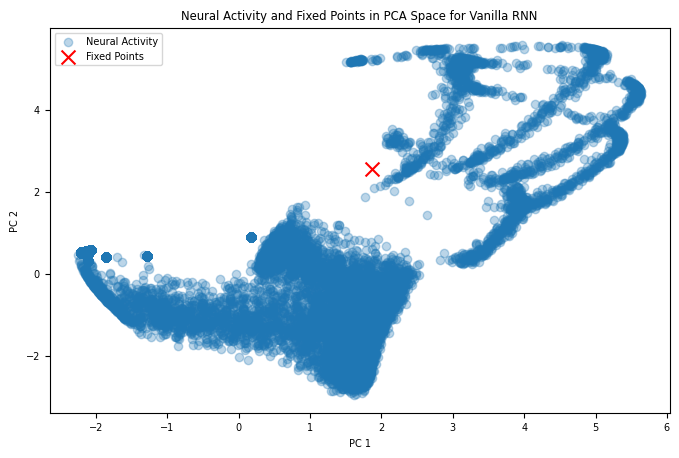

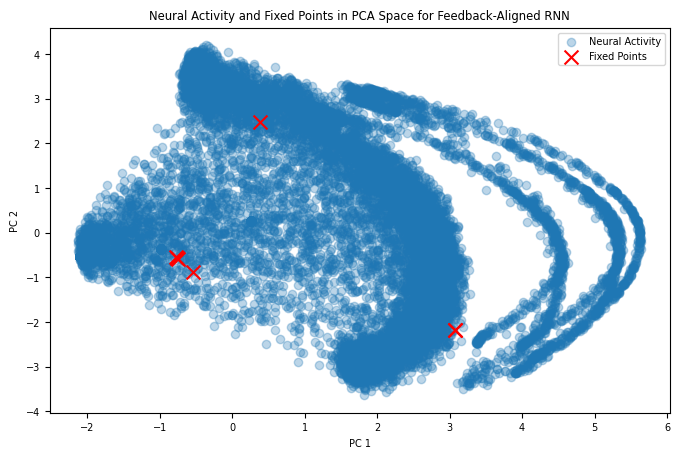

NameError: name 'ei_fixed_points' is not defined

In [48]:
def plot_fixed_points(activity_dict, fixed_points, title_suffix=''):
  # Collect activity from all trials
  activity_list = []
  for trial_activity in activity_dict.values():
      activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
  activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

  # Convert fixed points list to numpy array if it's not already
  fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]

  # Apply PCA to project fixed points and neural activity into the same space
  from sklearn.decomposition import PCA
  import matplotlib.pyplot as plt

  pca = PCA(n_components=2)
  # Concatenate activity and fixed points for PCA projection
  activity_and_fp = np.concatenate([activity, fixed_points], axis=0)
  pca.fit(activity_and_fp)

  # Transform activity and fixed points
  activity_pc = pca.transform(activity)
  fixed_points_pc = pca.transform(fixed_points)

  # Plot activity and fixed points
  plt.figure(figsize=(8, 5))
  plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
  plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
  plt.xlabel("PC 1")
  plt.ylabel("PC 2")
  plt.title(f"Neural Activity and Fixed Points in PCA Space for {title_suffix}")
  plt.legend()
  plt.show()

plot_fixed_points(activity_dict, fixed_points, title_suffix='Vanilla RNN')
plot_fixed_points(fa_activity_dict, fa_fixed_points, title_suffix='Feedback-Aligned RNN')
plot_fixed_points(ei_activity_dict, ei_fixed_points, title_suffix='Excitatory-Inhibitory RNN')



---

